<a href="https://colab.research.google.com/github/tgresearch/DSA-Python/blob/main/nsmc_classification_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 네이버 영화 리뷰 감성분류 모델 구현(RNN)
- 데이터 전처리 : nsmc_preprocessing.ipynb

## 라이브러리 임포트

In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 구글 드라이브 마운트

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 학습 데이터 로드

In [3]:
DATA_PATH = '/content/drive/MyDrive/nlpdata/nsmc/'

train_input = np.load(open(DATA_PATH + 'train_input.npy', 'rb'))
train_label = np.load(open(DATA_PATH + 'train_label.npy', 'rb'))
prepro_configs = json.load(open(DATA_PATH + 'data_configs.json', 'r'))

## 모델 하이퍼파라미터 정의

In [4]:
model_name = 'nsmc_rnn'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_dimension': 100,
        'dropout_rate': 0.2,
        'lstm_dimension': 150,
        'dense_dimension': 150,
        'output_dimension':1}

## 모델 정의

In [5]:
class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(RNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['dense_dimension'],
                           activation=tf.keras.activations.tanh)
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [6]:
model = RNNClassifier(**kargs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
es = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
checkpoint_path = DATA_PATH + '/weights_rnn.h5'
mc = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

## 모델 학습 
- GPU 사용 : 런타임 -> 런타임 유형 변경 -> GPU

In [8]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[es, mc])

Epoch 1/5
1055/1055 [==============================] - 72s 38ms/step - loss: 0.4753 - accuracy: 0.7631 - val_loss: 0.4033 - val_accuracy: 0.8173

Epoch 00001: val_accuracy improved from -inf to 0.81727, saving model to /content/drive/MyDrive/nlpdata/nsmc/weights_rnn.h5
Epoch 2/5
1055/1055 [==============================] - 39s 37ms/step - loss: 0.3368 - accuracy: 0.8515 - val_loss: 0.3833 - val_accuracy: 0.8264

Epoch 00002: val_accuracy improved from 0.81727 to 0.82640, saving model to /content/drive/MyDrive/nlpdata/nsmc/weights_rnn.h5
Epoch 3/5
1055/1055 [==============================] - 39s 37ms/step - loss: 0.2786 - accuracy: 0.8806 - val_loss: 0.4108 - val_accuracy: 0.8243

Epoch 00003: val_accuracy did not improve from 0.82640
Epoch 4/5
1055/1055 [==============================] - 38s 36ms/step - loss: 0.2375 - accuracy: 0.9004 - val_loss: 0.4273 - val_accuracy: 0.8233

Epoch 00004: val_accuracy did not improve from 0.82640


## 결과 플롯

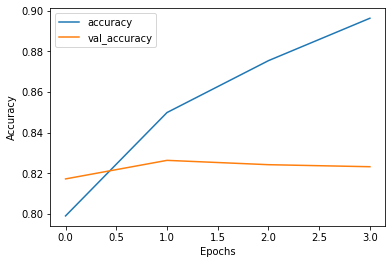

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

## 모델 평가

In [10]:
test_input = np.load(open(DATA_PATH + 'test_input.npy', 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
test_label_data = np.load(open(DATA_PATH + 'test_label.npy', 'rb'))

model.load_weights(os.path.join(DATA_PATH, 'weights_rnn.h5'))

In [11]:
model.evaluate(test_input, test_label_data)

1563/1563 [==============================] - 4s 3ms/step - loss: 0.3896 - accuracy: 0.8256


[0.38960543274879456, 0.8255800008773804]